# Comparison between OT and GW registration methods

## Imports and magics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from functools import partial

from ot import emd
from ot.utils import dist 
from ot.gromov import gromov_wasserstein
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.io import loadmat
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from IPython.display import HTML

from otimage import imagerep, readers
from otimage.utils import plot_maxproj

## Implement registration methods

In [3]:
def normalized_dist_mtx(pts_1, pts_2, metric):
    """Return distance matrix normalized by median."""
    
    mtx_nn = dist(pts_1, pts_2, metric=metric)
    return mtx_nn / np.median(mtx_nn)

def compute_ot(pts_1, pts_2, wts_1, wts_2):
    """Normalize weights and compute OT matrix."""
    
    # Normalize weights
    p_1 = wts_1 / np.sum(wts_1)
    p_2 = wts_2 / np.sum(wts_2)

    # Normalized distance matrix 
    c_mtx = normalized_dist_mtx(pts_1, pts_2, 'sqeuclidean')
    
    # Compute transport plan
    return emd(p_1, p_2, c_mtx, log=True)

def compute_gw(pts_1, pts_2, wts_1, wts_2):
    """Normalize weights and compute OT matrix."""
    
    # Normalize weights
    p_1 = wts_1 / np.sum(wts_1)
    p_2 = wts_2 / np.sum(wts_2)

    # Normalized distance matrices
    c_1 = normalized_dist_mtx(pts_1, pts_1, metric='sqeuclidean')
    c_2 = normalized_dist_mtx(pts_2, pts_2, metric='sqeuclidean')
    
    # Compute transport plan
    return gromov_wasserstein(c_1, c_2, p_1, p_2, 'square_loss', log=True)

def transport_regression_poly(pts_1, pts_2, transport_mtx, degree):
    """Compute weighted polynomial regression using transport plan"""
    
    # Get pairs of points with values above threshold, and corresponding weights from P matrix
    idx_1, idx_2 = np.nonzero(transport_mtx)
    x = pts_1[idx_1]
    y = pts_2[idx_2]
    smp_wt = transport_mtx[idx_1, idx_2]

    # Use sklearn to minimize cost function
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('linear', LinearRegression(fit_intercept=True))
    ])
    model.fit(x, y, linear__sample_weight=smp_wt)
   
    return model

def ot_registration(pts_1, pts_2, wts_1, wts_2, degree, n_iter):
    """EM-based registration method using optimal transport plan."""
    
    model = [None] * n_iter
    t_mtx = [None] * n_iter
    ot_log = [None] * n_iter
    
    pf_pts = [pts_1] + [None] * n_iter
    
    for i in range(n_iter):
        
        # E-step: Compute OT plan between current points and target points
        t_mtx[i], ot_log[i] = compute_ot(pf_pts[i], pts_2, wts_1, wts_2)
        
        # M-step: Compute new mapping using transport plan
        model[i] =  transport_regression_poly(pts_1, pts_2, t_mtx[i], degree)
       
        # Update points 
        pf_pts[i + 1] = model[i].predict(pts_1)
       
    debug = {
        'model': model,
        'pf_pts': pf_pts,
        't_mtx': t_mtx,
        'ot_log': ot_log,
    }
    
    return model[-1], debug

def gw_registration(pts_1, pts_2, wts_1, wts_2, degree, n_iter):
    """EM-based registration method using Gromov-Wasserstein transport plan."""
    
    model = [None] * n_iter
    t_mtx = [None] * n_iter
    gw_log = [None] * n_iter
    
    pf_pts = [pts_1] + [None] * n_iter
    
    for i in range(n_iter):
        
        # E-step: Compute OT plan between current points and target points
        t_mtx[i], gw_log[i] = compute_gw(pf_pts[i], pts_2, wts_1, wts_2)
        
        # M-step: Compute new mapping using transport plan
        model[i] =  transport_regression_poly(pts_1, pts_2, t_mtx[i], degree)
       
        # Update points 
        pf_pts[i + 1] = model[i].predict(pts_1)
       
    debug = {
        'model': model,
        'pf_pts': pf_pts,
        't_mtx': t_mtx,
        'gw_log': gw_log,
    }
    
    return model[-1], debug

## Load Zimmer data

**TODO: Replace this with synthetic data once I get it from Amin**

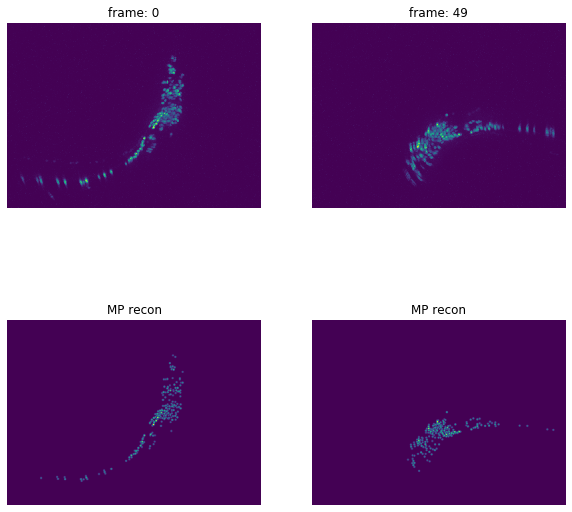

In [4]:
# Frames to load
t_start = 0
n_frames = 50
t_vals = range(t_start, t_start + n_frames)

# Load frames from dataset
img_path = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'
with readers.ZimmerReader(img_path) as reader:
    img = [reader.get_frame(t) for t in t_vals]
    img_shape = img[0].shape

# Load MP components
mp_path = '/home/mn2822/Desktop/WormOT/data/zimmer/mp_components/mp_0000_0050.mat'
mp_data = loadmat(mp_path)
cov = mp_data['cov']
pts = [mp_data['means'][t, :, :] for t in t_vals]
wts = [mp_data['weights'][t, :, 0] for t in t_vals]

# Reconstruct images from MPs
mp_img = [imagerep.reconstruct_image(pts[i], [cov], wts[i], img_shape) for i in range(n_frames)]

# Indices to plot
k1 = 0
k2 = -1
  
plt.figure(figsize=(10, 10))

plt.subplot(221)
plot_maxproj(img[k1])
plt.title(f'frame: {t_vals[k1]}')
plt.axis('off')

plt.subplot(222)
plot_maxproj(img[k2])
plt.title(f'frame: {t_vals[k2]}')
plt.axis('off');

plt.subplot(223)
plot_maxproj(mp_img[k1])
plt.title('MP recon')
plt.axis('off')

plt.subplot(224)
plot_maxproj(mp_img[k2])
plt.title('MP recon')
plt.axis('off');

## Compare registration methods

### Choose registration methods to compare

In [5]:
reg_1 = partial(ot_registration, degree=3, n_iter=50)
reg_2 = partial(gw_registration, degree=3, n_iter=50)
reg_labels = ['OT', 'GW']

### Register all frames using both methods

In [6]:
models_1 = [None] * (n_frames - 1)
debug_1 = [None] * (n_frames - 1)

models_2 = [None] * (n_frames - 1)
debug_2 = [None] * (n_frames - 1)

for t in range(n_frames - 1):
    
    models_1[t], debug_1[t] = reg_1(pts[0], pts[t + 1], wts[0], wts[t + 1])
    models_2[t], debug_2[t] = reg_2(pts[0], pts[t + 1], wts[0], wts[t + 1])

### Reconstruct frames using mappings learned using both methods

In [7]:
rec_1 = [mp_img[0]] + [None] * (n_frames - 1)
rec_2 = [mp_img[0]] + [None] * (n_frames - 1)

for t in range(1, n_frames):
    
    pf_pts_1 = models_1[t - 1].predict(pts[0])
    rec_1[t] = imagerep.reconstruct_image_2(pf_pts_1, wts[0], cov, img_shape)
    
    pf_pts_2 = models_2[t - 1].predict(pts[0])
    rec_2[t] = imagerep.reconstruct_image_2(pf_pts_2, wts[0], cov, img_shape)

### Plot single frame next to reconstruction

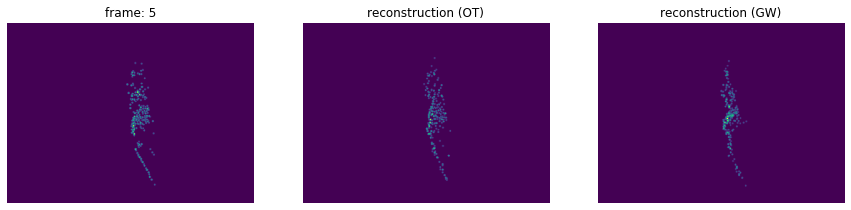

In [8]:
t = 5

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj(mp_img[t])
plt.title(f'frame: {t}')
plt.axis('off')
        
plt.subplot(132)
plot_maxproj(rec_1[t])
plt.title(f'reconstruction ({reg_labels[0]})')
plt.axis('off')

plt.subplot(133)
plot_maxproj(rec_2[t])
plt.title(f'reconstruction ({reg_labels[1]})')
plt.axis('off');

### Create video of all frame reconstructions

In [9]:
fig, (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(15, 15))

ax_1.set_title('frame')
ax_2.set_title(f'reconstruction ({reg_labels[0]})')
ax_3.set_title(f'reconstruction ({reg_labels[1]})')

ax_1.axis('off')
ax_2.axis('off')
ax_3.axis('off')

def animate(t):
    
    plot_maxproj(mp_img[t], ax=ax_1, animated=True)
    plot_maxproj(rec_1[t], ax=ax_2, animated=True)
    plot_maxproj(rec_2[t], ax=ax_3, animated=True)
    
ani = animation.FuncAnimation(fig, animate, n_frames)
ani.save('reg_compare.mp4')

# Prevent double-display of animation
plt.close()

# Display animation in notebook
HTML(ani.to_html5_video())